In [ ]:
import pandas as pd

# load frozen player–game table with labels
pg = pd.read_parquet("../data_processed/player_game_2022.parquet")

# keep only rows with labels (Week 2 logic)
pg.head()

,game_id,player_id,snaps,st_snaps,season,week,full_name,team,position,status,run_snaps,goal_to_go_snaps,short_yardage_snaps,red_zone_snaps,penalty_contact_snaps
0,2022_01_BAL_NYJ,33099,84,0,2022,1,Joe Flacco,NYJ,QB,ACT,17,7,4,13,0
1,2022_01_BAL_NYJ,33131,49,1,2022,1,Calais Campbell,BAL,DL,ACT,12,1,6,8,0
2,2022_01_BAL_NYJ,37145,54,0,2022,1,Justin Houston,BAL,LB,ACT,8,1,2,7,0
3,2022_01_BAL_NYJ,37778,32,0,2022,1,Josh Bynes,BAL,LB,ACT,13,3,1,3,0
4,2022_01_BAL_NYJ,38557,60,0,2022,1,Kevin Zeitler,BAL,OL,ACT,19,0,7,10,0


In [28]:
import pandas as pd

# Load injury file
inj = pd.read_csv("../data_raw/injuries_2022.csv")

# Weekly concussion flags
inj = inj.sort_values(["gsis_id", "season", "week"])

inj["concussion_week"] = (
    inj["report_primary_injury"].str.contains("concussion", case=False, na=False)
    | inj["report_secondary_injury"].str.contains("concussion", case=False, na=False)
).astype(int)

inj["concussion_onset_week"] = (
    (inj["concussion_week"] == 1)
    & (inj.groupby("gsis_id")["concussion_week"].shift(1).fillna(0) == 0)
).astype(int)

# Build mapping between numeric player_id and gsis_id using overlapping identifiers
pg_key = pg[["player_id", "season", "week", "team", "position", "full_name"]].drop_duplicates()
inj_key = inj[["gsis_id", "season", "week", "team", "position", "full_name"]].drop_duplicates()

map_df = pg_key.merge(inj_key, on=["season", "week", "team", "position", "full_name"], how="inner")
player_map = map_df[["player_id", "gsis_id"]].drop_duplicates()

# Attach gsis_id onto player-game table
pg = pg.merge(player_map, on="player_id", how="left")

# Create onset events shifted back one week
onsets = inj.loc[inj["concussion_onset_week"] == 1, ["gsis_id", "season", "week"]].copy()
onsets["event_week"] = onsets["week"] - 1

# Merge to mark player-game concussion events
pg = pg.merge(
    onsets[["gsis_id", "season", "event_week"]],
    left_on=["gsis_id", "season", "week"],
    right_on=["gsis_id", "season", "event_week"],
    how="left",
    indicator=True
)

pg["concussion_event"] = (pg["_merge"] == "both").astype(int)

# Clean merge artifacts
pg = pg.drop(columns=["event_week", "_merge"])

pg["concussion_event"].value_counts()

concussion_event
0    26332
1       49
Name: count, dtype: int64

In [ ]:
# Target
y = pg["concussion_event"]

# Features (Week 1)
feature_cols = [
    "snaps",
    "st_snaps",
    "run_snaps",
    "short_yardage_snaps",
    "goal_to_go_snaps",
    "red_zone_snaps",
    "penalty_contact_snaps",
]

X = pg[feature_cols]

X.shape, y.shape

((26381, 7), (26381,))

In [30]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((21104, 7),
 (5277, 7),
 np.float64(0.0018479909021986353),
 np.float64(0.0018950161076369148))

In [ ]:
from sklearn.linear_model import LogisticRegression

# initialize logistic regression
logit = LogisticRegression(
    penalty="l2",
    solver="liblinear",  
    max_iter=1000,
    random_state=42
)

# fit model
logit.fit(X_train, y_train)

logit

c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

In [33]:
# predicted probabilities on test set
y_test_prob = logit.predict_proba(X_test)[:, 1]

y_test_prob[:10], y_test_prob.min(), y_test_prob.max()

(array([0.00052724, 0.00229532, 0.00206382, 0.00109434, 0.00046124,
        0.00421083, 0.00014534, 0.00947647, 0.00078279, 0.00138549]),
 np.float64(2.4697936026439457e-06),
 np.float64(0.010130079175931873))

In [34]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_test, y_test_prob)

pr_auc

0.018620378008200926

In [35]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_test_prob)

brier

0.0018837475337417687

In [36]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


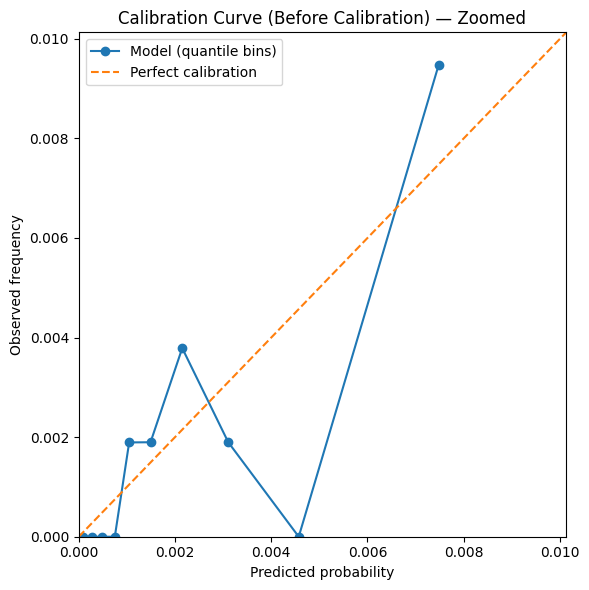

(10,
 array([9.70992215e-05, 2.78608990e-04, 4.90725571e-04, 7.48834501e-04,
        1.04697177e-03, 1.49125234e-03, 2.15017971e-03, 3.10660235e-03,
        4.57115081e-03, 7.47744729e-03]),
 array([0.        , 0.        , 0.        , 0.        , 0.00189394,
        0.00189753, 0.00378788, 0.00189753, 0.        , 0.0094697 ]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# use quantile bins so we actually get multiple points
prob_true_q, prob_pred_q = calibration_curve(
    y_test,
    y_test_prob,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_q, prob_true_q, marker="o", label="Model (quantile bins)")

# zoom into the range where your probabilities actually live
max_p = float(np.max(y_test_prob))
plt.plot([0, max_p], [0, max_p], linestyle="--", label="Perfect calibration")

plt.xlim(0, max_p)
plt.ylim(0, max_p)

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (Before Calibration) — Zoomed")
plt.legend()
plt.tight_layout()
plt.show()

len(prob_pred_q), prob_pred_q, prob_true_q

In [39]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    estimator=logit,  
    method="sigmoid",
    cv=5
)

calibrated_model.fit(X_train, y_train)

y_test_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]

y_test_prob_cal.min(), y_test_prob_cal.mean(), y_test_prob_cal.max()


c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was depr

(np.float64(0.00013751071618719487),
 np.float64(0.0019342847870382589),
 np.float64(0.005552219438163347))

In [40]:
from sklearn.metrics import average_precision_score

pr_auc_cal = average_precision_score(y_test, y_test_prob_cal)

pr_auc_cal

0.015315335786930439

In [41]:
from sklearn.metrics import brier_score_loss

brier_uncal = brier_score_loss(y_test, y_test_prob)
brier_cal = brier_score_loss(y_test, y_test_prob_cal)

brier_uncal, brier_cal

(0.0018837475337417687, 0.001886916804199356)